In [25]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

## Building the dataset

The dataset to be used is a subset of an existing dataset found on [kaggle](https://www.kaggle.com/datasets/sovitrath/sports-image-dataset?datasetId=680510&sortBy=dateRun&tab=profile). The original dataset had 22 different sports from which 15 were choosen for our subset. The choice of the sports was not arbitrary, we chose to keep a variety of sports that included some very similar to each other and others that are more easily destinguisable, so we can still explore the capabilities of our approach.

Maping each sport name to an id and saving it in a dictionary for easy use throughout the code.

In [26]:
labels = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}


def get_key(val):
    for key, value in labels.items():
        if val == value:
            return key
 
    return False

In [27]:
def build_csv(labels):
    directory=".\data\images"
    data=[]
    for root, subdirectories, files in os.walk(directory):
        if any(map(lambda p: p[0] == '.', subdirectories)):
            continue
        for subdirectory in subdirectories:
            label=get_key(subdirectory)
            for r, s, files in os.walk(os.path.join(root, subdirectory)):
                for f in files:
                    data.append([os.path.join(root, subdirectory,f),label])
                    

    df= pd.DataFrame(data, columns=['path', 'label'])

    df.to_csv("./data/data.csv", index=False)


#build_csv(labels)

In [28]:
df = pd.read_csv("./data/data.csv")
df.head(5)

,path,label
0,.\data\images\badminton\00000000.jpg,0
1,.\data\images\badminton\00000001.jpg,0
2,.\data\images\badminton\00000002.png,0
3,.\data\images\badminton\00000003.jpg,0
4,.\data\images\badminton\00000004.jpg,0


In [29]:
len(df['label'].unique())

15

<function matplotlib.pyplot.axes(arg=None, **kwargs)>

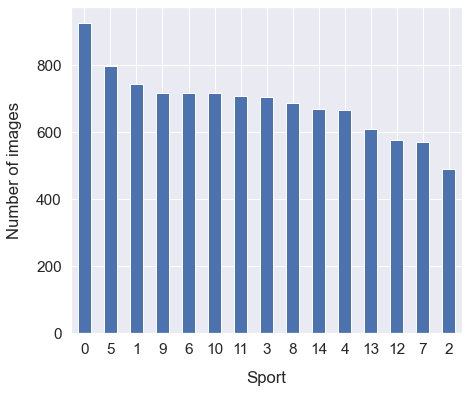

In [30]:
sns.set(font_scale=1.4)
df['label'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Number of images", labelpad=14)
plt.xlabel("Sport", labelpad=14)
plt.axes